# **Microproyecto 2: Alcanzando los objetivos de desarrollo sostenible. Un aporte desde el machine learning**

---



### **Contexto**

La Organización de las Naciones Unidas (ONU) adopta, el 25 de septiembre del año 2015, la Agenda 2030 para el desarrollo sostenible, cuyo fin es reducir la pobreza, garantizar acceso a la salud y educación, buscar igualdad de género y oportunidades y disminuir el impacto ambiental, entre otros propósitos. A tal efecto, define 17 objetivos de desarrollo sostenible (ODS) y 169 metas (derivadas de los diferentes ODS). Dentro del trabajo en conjunto de diferentes entes para alcanzar el cumplimiento de los objetivos de desarrollo sostenible definidos en la Agenda 2030, muchas entidades tienen como función el seguimiento y la evaluación de las políticas públicas y su impacto a nivel social. Este es el caso del Fondo de Población de las Naciones Unidas (UNFPA, por sus siglas en inglés), que, junto con instituciones públicas y haciendo uso de diferentes herramientas de participación ciudadana, busca identificar problemas y evaluar soluciones actuales, relacionando la información con los diferentes ODS.

Uno de los procesos que requiere de un mayor esfuerzo es la interpretación y análisis de la información textual procedente de diferentes fuentes implicadas en la planeación participativa para el desarrollo a nivel territorial, ya que es una tarea que consume gran cantidad recursos y para la cual se requiere de expertos que relacionen los textos con los ODS. Este conocimiento facilitaría la toma de decisiones con base en la opinión de la población y permitiría encaminar las políticas públicas de manera más informada para el cumplimiento de la Agenda 2030.

**A. Objetivo.**

El objetivo del proyecto es desarrollar una solución, basada en técnicas de procesamiento del lenguaje natural y machine learning, que permita clasificar automáticamente un texto según los 17 ODS, ofreciendo una forma de presentación de resultados a través de una herramienta de fácil comprensión para el usuario final.


# Desarrollo
---

El desarrollo del proyecto ha sido divido en seis etapas:

1. Procesamiento inicial de datos
2. Preprocesamiento de textos en español
3. EDA
4. Etapa de modelado - Clases no balanceadas
5. Etapa de modelado - Clases balanceadas
6. Conclusiones.


 ##  **1. Procesamiento inicial de datos**

En esta sección inicial, se realizará la carga de las librerías necesarias, organizadas en tres categorías:

* Librerías para manipulación de datos
* Librerías para procesamiento de lenguaje natural
* Librerías para Machine Learning

In [ ]:
# Configuración de datos:
from tqdm import tqdm
tqdm.pandas() # Habilitar tqdm para pandas
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os # Operaciones de sistema
import unicodedata # Normalización de texto caracteres especiales
import unidecode # Normalización de texto acentos

# NLP libraries
import nltk # Procesamientl NLP
from nltk.corpus import stopwords # Lista de palabras vacías múltiples idiomas
from nltk.stem import SnowballStemmer # Algoritmo de stemming
from nltk.tokenize import RegexpTokenizer # Tokenización basada en RE
from wordcloud import WordCloud # Creación nubes de palabras

# ML Libraries
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer # Conversión de texto a vectores (IF-ID)
from sklearn.decomposition import TruncatedSVD # Reducción de dimensionalidad mediante SVD
from sklearn.linear_model import LogisticRegression # Regresión lógistica
from sklearn.naive_bayes import ComplementNB # Naive complementario
from sklearn.ensemble import RandomForestClassifier # Random forest
from xgboost import XGBClassifier # Algoritmo XGboost
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import (train_test_split, # Validación cruzada estratificada
                                     RandomizedSearchCV, # Busqueda aleatoria de hiperparámetros
                                     GridSearchCV,
                                     StratifiedKFold) # Validación cruzada estratificada
from sklearn.metrics import (classification_report, # Precisión, recall, F1-score
                             ConfusionMatrixDisplay, # Matriz de confusión
                             f1_score) # F1 score
from imblearn.over_sampling import SMOTE # SMOTE to oversample
from sklearn.pipeline import Pipeline # Creación de flujos de procesamiento
from sklearn.svm import SVC # Importing SVC as classifier


### **Cargar datos**

Se definirá un RANDOM_STATE para garantizar la reproducibilidad de los resultados a lo largo del ejercicio. Además, se cargará el conjunto de datos y se visualizarán las dos primeras observaciones para verificar que la información se haya cargado correctamente.

In [ ]:
# Configuración general
RANDOM_STATE = 50 # Creando un random state que se utilizará
# a lo largo del ejercicio
raw_data = pd.read_excel("./data/Train_textosODS.xlsx")
raw_data.info()
raw_data.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  9656 non-null   object
 1   ODS     9656 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 151.0+ KB


,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6


### Verificación y Eliminación de Duplicados.

In [ ]:
raw_data.duplicated().sum()

0

### **2. Preprocesamiento de textos en español**

La etapa de preprocesamiento de texto es fundamental para cualquier algoritmo de clasificación, ya que ayuda a reducir el ruido y la variabilidad, mejora el rendimiento de los modelos y facilita su capacidad de generalización.

Para este proceso, se utilizaron las siguientes herramientas:

* NLTK: Manejo de texto y eliminación de palabras vacías.
* Unidecode: Eliminación de acentos y caracteres especiales.
* Regexp: Tokenización de palabras mediante expresiones regulares.
* SnowballStemmer: Reducción de palabras a su raíz, permitiendo agrupar términos con el mismo significado.

A continuación, se definirá una función para implementar el preprocesamiento de textos en español utilizando NLTK.

In [ ]:
nltk.download('stopwords') # Descargar stopwords
def preprocesamiento_es(texto): #Creación de una función para automatizar el procesamiento de texto
    texto = unidecode.unidecode(texto.lower())  # Manejo robusto de acentos
    texto = ''.join([c for c in texto if c.isalpha() or c == ' ']) # Eliminación caracters no alfabéticos

    tokenizer = RegexpTokenizer(r'\w\w+') # Tokenización
    stemmer = SnowballStemmer('spanish') # Reducción de palabras de raíz
    stop_words = set(stopwords.words('spanish')) # Eliminación de palabras vacias

    tokens = tokenizer.tokenize(texto)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)


# Aplicación de la función generada a los datos
raw_data.dropna(subset=['textos'], inplace=True)
raw_data['texto_procesado'] = raw_data['textos'].progress_apply(preprocesamiento_es)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 9656/9656 [00:37<00:00, 259.74it/s]


## **3. EDA**

Antes de iniciar la etapa de modelado, se llevará a cabo un Análisis Exploratorio de Datos (EDA) para comprender mejor la distribución y características del conjunto de datos.

Como se muestra en la siguiente figura, se observa un desbalance de clases en la cantidad de documentos asociados a algunos de los Objetivos de Desarrollo Sostenible (ODS). Este desbalance es especialmente notable en los documentos clasificados bajo los ODS 2, 8, 9, 10, 12 y 15.

Este desbalance nos da una pista anticipada que el modelo podría tener dificultades al predecir algunas de estas clases sub-representadas.

#### **Figura 1**

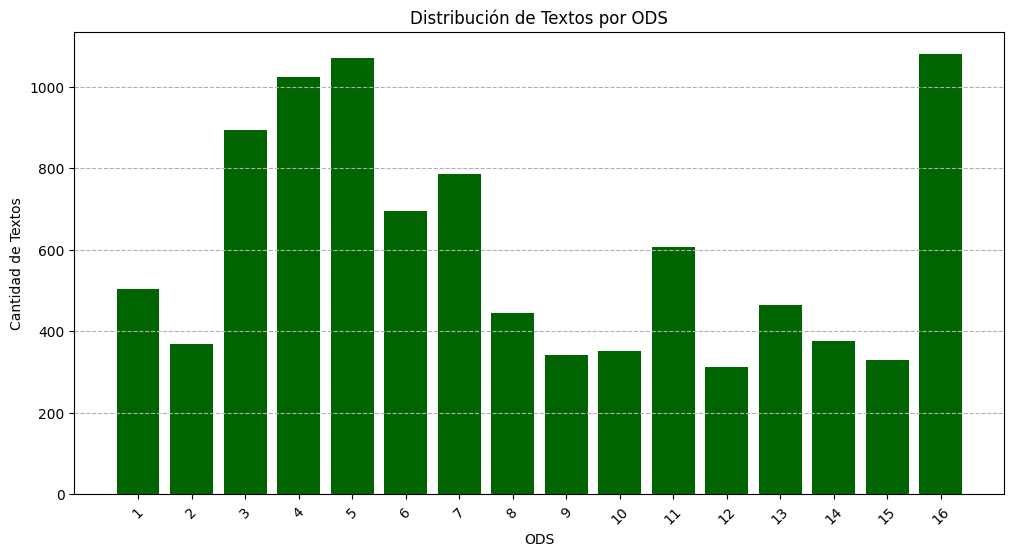

In [ ]:
# Análisis exploratorio
# ==============================================================================
plt.figure(figsize=(12,6))
conteo_ods = raw_data['ODS'].value_counts().sort_index()
plt.bar(conteo_ods.index.astype(str), conteo_ods.values, color='darkgreen')
plt.title('Distribución de Textos por ODS')
plt.xlabel('ODS')
plt.ylabel('Cantidad de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()
# ==============================================================================


A continuación, se realizará una representación numérica de los textos utilizando TF-IDF, seleccionando solo las 5000 palabras más relevantes para reducir la dimensionalidad. Luego, se reducirá la dimensionalidad de los datos, transformando las dimensiones de TF-IDF a un espacio de solo 2 dimensiones, lo que permitirá visualizar cómo se agrupan los textos en función de sus características semánticas.

La Figura 2 nos muestra que los textos están relacionados con los ODS y forman grupos claramente diferenciados. Esto indica que el preprocesamiento realizado ha generado características representativas, lo que sugiere que se podrían obtener resultados positivos en la etapa de modelado.

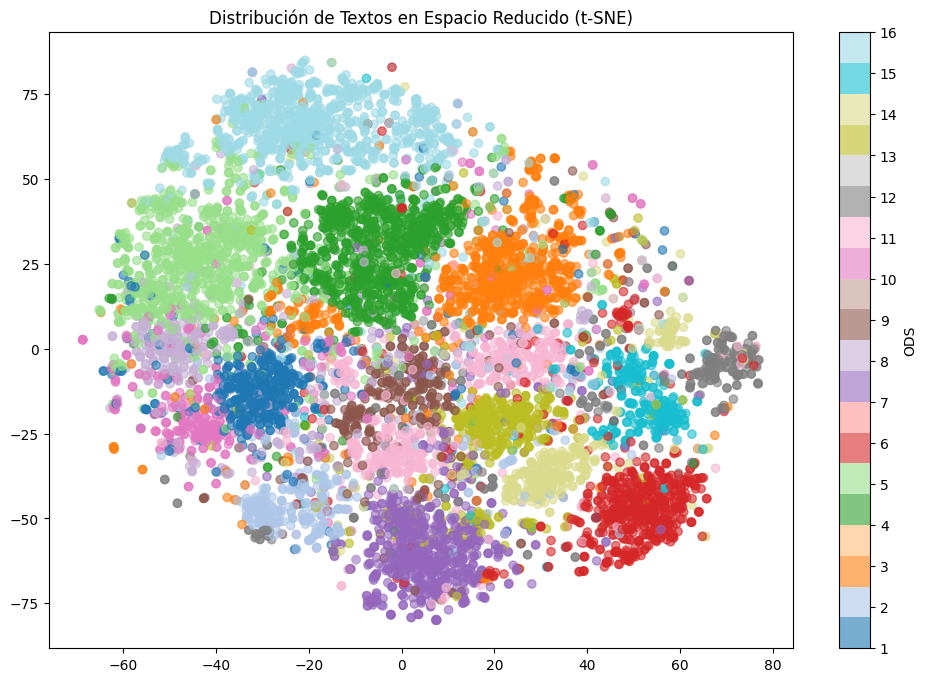

In [ ]:

# NEW: Visualización del espacio de características
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(raw_data['texto_procesado'])
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(12,8))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=raw_data['ODS'], cmap='tab20', alpha=0.6)
plt.title("Distribución de Textos en Espacio Reducido (t-SNE)")
plt.colorbar(scatter, ticks=range(1,18), label="ODS")
plt.show()

## **4. Etapa de modelado - Clases no balanceadas**

En esta etapa del ejercicio, se procederá con la división de los datos. Se definirá un pipeline de preparación para asegurar que los datos estén listos para el modelo. A continuación, se llevará a cabo la selección del mejor modelo, evaluando distintas opciones para determinar cuál ofrece el mejor rendimiento en base a los datos disponibles.



A continuación, se realizará la división de los datos en conjuntos de entrenamiento (train) y prueba (test). Además, se ajustarán las etiquetas para que comiencen desde cero, ya que algunos algoritmos pueden encontrar conflictos al ejecutarlos si las etiquetas no siguen este formato.

In [ ]:
# Splitb
X_train, X_test, y_train, y_test = train_test_split(
    raw_data['texto_procesado'],
    raw_data['ODS'],
    test_size=0.2, # Realizando una partición 20, 80
    stratify=raw_data['ODS'], # Estratificación para mantener proporción de clases
    random_state=RANDOM_STATE
)
min_val = y_train.min()
y_train -= min_val # Ajuste para que etiquetas empiecen desde cero
y_test -= min_val # Ajuste para que etiquetas empiecen desde cero

### **Definición de Pipeline y Selección de modelos**

En la etapa de modelación se elaboró un flujo general que sigue los siguientes pasos:

1. Vectorización de texto con TF-IDF y Reducción de dimensionalidades TruncatedSVD
2. Prueba 3 modelos con diferentes configuraciones (Logistic Regression, Random Forest y LBGM)
3. Selección de hiperparámetros F1-macro
4. Evaluación en data no vistos (test)
5. Diagnóstico detallado con métricas y ejemplos.

La vectorización de texto TF-IDF es necesaria para convertir los textos en representaciones numéricas, que posteriormente serán procesadas por los modelos de ML. A este proceso se anexa la reducción de dimensionalidad en datos dispersos (**TruncatesSVD**) para mejorar eficiencia computacional manteniendo la mayor cantidad de información posible, incluyendo la semántica y el contexto cuando se aplica a datos tipo texto.

La selección del modelo se realizó según los siguientes criterios:


| Modelo                          | Beneficio |
|---------------------------------|-------------------------------------------------------------------------------------|
| Regresión Logística             | Fácil de interpretar y eficaz para capturar relaciones lineales entre palabras y categorías. |
| Random Forest                   | Modelo robusto que maneja relaciones no lineales y ayuda a controlar el sobreajuste (overfitting). |
| LGBM | Modelo de boosting ligero que maneja bien datos desbalanceados |


Se eligió la métrica F1 como criterio de optimización debido al desbalance de clases encontrado en el análisis exploratorio.

También se realizó una búsqueda de hiperparámetros con RandomizedSearch, que ofrece una alternativa computacional eficiente y selecciona combinaciones aleatorias. De igual manera, se utilizó validación cruzada estratificada para asegurar que cada fold tenga la misma distribución de clases.




Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Mejor modelo encontrado: LogisticRegression
 Hiperparámetros óptimos: {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'svd__n_components': 100, 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 10, 'model': LogisticRegression(random_state=50)}
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       101
           1       0.81      0.73      0.77        74
           2       0.94      0.92      0.93       179
           3       0.89      0.95      0.92       205
           4       0.88      0.93      0.90       214
           5       0.90      0.95      0.92       139
           6       0.89      0.84      0.86       158
           7       0.64      0.61      0.62        89
           8       0.69      0.61      0.65        69
           9       0.77      0.59      0.67        70
          10       0.76      0.83      0.79       122
          11       0.75      0.76      0.75        62
          12       0.84

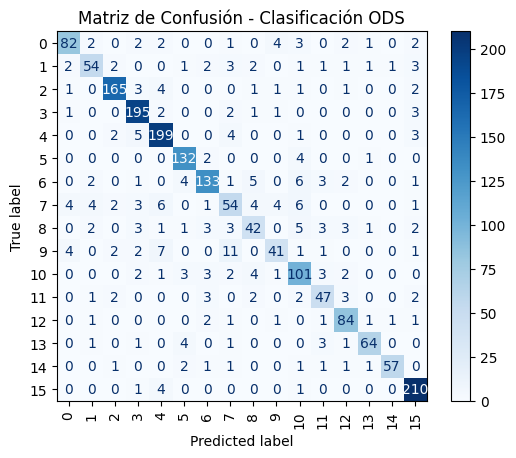


Texto: polit pesquer comun modific incorpor principi subyacent enfoqu otorg mayor import explot sosten recurs viv acuerd opinion cientif inform exig med caut...
ODS Real: 13 | ODS Predicho: 13

Texto: longitud km odra sext afluent mas grand mar baltic superfici medi mas agu subterrane establec vari poloni aproxim km republ chec km alemani km variaci...
ODS Real: 5 | ODS Predicho: 5

Texto: principi proporcional disfrut exit extraordinari ultim dec convert element basic adjud internacional constitucional derech fundamental sid adopt juec ...
ODS Real: 15 | ODS Predicho: 15

Texto: result proporcion general gener uso farmaceut franci mantuv torn terci pes tas sustitucion cercan dentr clas autoriz medicament panel seri util adopt ...
ODS Real: 2 | ODS Predicho: 4


In [ ]:
# Modelos
log_reg = LogisticRegression(random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
lgbm = LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)

## 1. Vectorización de texto con TF-IDF y Reducción de dimensionalidades
tsvd = TruncatedSVD(n_components=100)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=RANDOM_STATE)),
    ('model', log_reg)  # Modelo base, será reemplazado en la búsqueda de hiperparámetros
])

## 3. Prueba 3 modelos con diferentes configuraciones

# Espacio de búsqueda de hiperparámetros
param_dist = [

    {  # Logistic Regression
        "svd__n_components": [50, 100],
        'tfidf__max_features': [2000, 5000, None],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'model': [log_reg],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga'],
    },
    {  # Random Forest
        "svd__n_components": [50, 100],
        'tfidf__max_features': [2000, 5000, None],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'model': [rf],
        'model__n_estimators': [100, 300, 500, 1000],
        'model__max_depth': [5, 10, 20],
        'model__max_features': ['sqrt', 'log2']
    },
   {  # LightGBM
        "svd__n_components": [50, 100],
        'model': [lgbm],
        'model__n_estimators': [100, 300, 500],
        'model__max_depth': [5, 10, 20],
        'model__learning_rate': [0.01, 0.1, 0.2],
    }

]

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

busqueda = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=15,
    cv=kfold,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

busqueda.fit(X_train, y_train)

## 4. Evalúa en data no vistos (test)
mejor_modelo = busqueda.best_estimator_
y_pred = mejor_modelo.predict(X_test)
mejor_modelo_nombre = type(mejor_modelo.named_steps['model']).__name__  # Nombre del modelo
mejores_hiperparametros = busqueda.best_params_  # Hiperparámetros óptimos

print(f"\n Mejor modelo encontrado: {mejor_modelo_nombre}")
print(f" Hiperparámetros óptimos: {mejores_hiperparametros}")

## 5. Provee diagnóstico detallado con métricas y ejemplos.

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', xticks_rotation=90)
plt.title('Matriz de Confusión - Clasificación ODS')
plt.show()

textos_prueba = X_test.sample(4, random_state=RANDOM_STATE)
for texto, verdad in zip(textos_prueba, y_test.loc[textos_prueba.index]):
    prediccion = mejor_modelo.predict([texto])[0]
    print(f"\nTexto: {texto[:150]}...")
    print(f"ODS Real: {verdad} | ODS Predicho: {prediccion}")


## **5. Etapa de modelado - Clases balanceadas**

En el modelo anterior se observó que para los ODS 7, 8 y 9 se obtuvieron unas métricas de clasificación bastante bajas, lo cual se debe al desbalance de clases que fue descubierto en el EDA.

Una posible solución para el desbalance de clases es utilizar una técnica para balancear los datos. En este caso se utilizará la técnica de SMOTE, que generará datos sintéticos para las clases minoritarias y mejorará el balance de clases, con un énfasis especial en el F1.

En lo que respecta a los modelos realizados, la única diferencia con respecto al anterior modelo es que se implementó un nuevo pipeline que soporta la reducción de dimensionalidades de SMOTE.

El siguiente código se divide en cinco pasos:

1. Balanceo de clases con SMOTE
2. Prueba 3 modelos con diferentes configuraciones (Logit, Random Fores y LBGM)
3. Seleccion de hiperparámetros F1-macro
4. Evaluaación en data no vistos (test)
5. Diagnóstico detallado con métricas y ejemplos

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Mejor modelo encontrado: LogisticRegression
 Hiperparámetros óptimos: {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'svd__n_components': 100, 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 10, 'model': LogisticRegression(random_state=50)}

 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       101
           1       0.81      0.78      0.79        74
           2       0.95      0.90      0.93       179
           3       0.90      0.93      0.92       205
           4       0.88      0.91      0.90       214
           5       0.90      0.95      0.92       139
           6       0.90      0.84      0.87       158
           7       0.60      0.61      0.60        89
           8       0.62      0.64      0.63        69
           9       0.79      0.64      0.71        70
          10       0.76      0.81      0.79       122
          11       0.77      0.79      0.78      

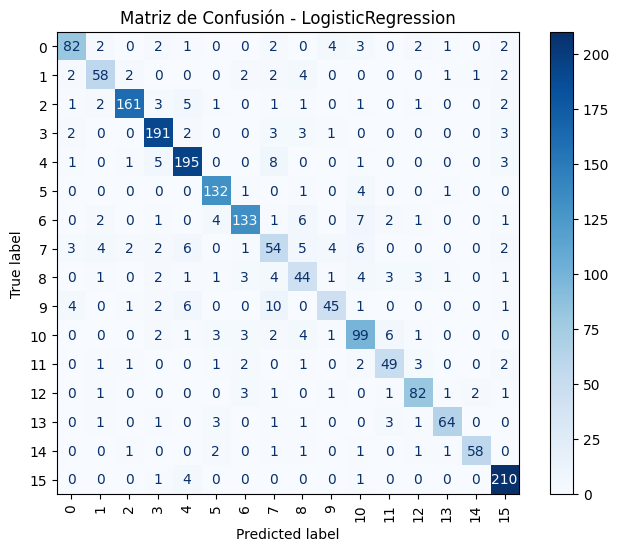

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
# Convertir a pandas Series para evitar errores de formato
X_train = pd.Series(X_train).astype(str)
X_test = pd.Series(X_test).astype(str)

# Modelos
log_reg = LogisticRegression(random_state=RANDOM_STATE)
bayes = ComplementNB()
rf = RandomForestClassifier(random_state=RANDOM_STATE)
lgbm = LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)

# Pipeline con SMOTE
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=100, random_state=RANDOM_STATE)),
    ('smote', SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)),
    ('model', log_reg)  # Modelo base
])

# Espacio de búsqueda de hiperparámetros
param_dist = [
    {  # Logistic Regression
        "svd__n_components": [50, 100],
        'tfidf__max_features': [2000, 5000, None],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'model': [log_reg],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga'],
    },
    {  # Random Forest
        "svd__n_components": [50, 100],
        'tfidf__max_features': [2000, 5000, None],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'model': [rf],
        'model__n_estimators': [100, 300, 500, 1000],
        'model__max_depth': [5, 10, 20],
        'model__max_features': ['sqrt', 'log2'],
    },
    {  # LightGBM
        "svd__n_components": [50, 100],
        'model': [lgbm],
        'model__n_estimators': [100, 300, 500],
        'model__max_depth': [5, 10, 20],
        'model__learning_rate': [0.01, 0.1, 0.2],
    }
]

# Configuración de validación cruzada
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Búsqueda de hiperparámetros con RandomizedSearchCV
busqueda = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=15,
    cv=kfold,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

# Ajuste del modelo
busqueda.fit(X_train, y_train)

# Evaluación del mejor modelo
mejor_modelo = busqueda.best_estimator_
mejor_modelo_nombre = type(mejor_modelo.named_steps['model']).__name__
mejores_hiperparametros = busqueda.best_params_

print(f"\n Mejor modelo encontrado: {mejor_modelo_nombre}")
print(f" Hiperparámetros óptimos: {mejores_hiperparametros}")

# Predicciones
y_pred = mejor_modelo.predict(X_test)

print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax, xticks_rotation=90)
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
plt.show()



# Conclusiones

Se realizó la búsqueda del mejor modelo en dos grandes etapas. En la primera se utilizaron los datos datos originales, y en la segunda se usó SMOTE para balancear las clases.


En la **etapa 1** se probaron varios algoritmos de machine learning (``logistic regression, random forest, and LBGM``) junto con la optimización de sus hiperparámetros usando ``RandomizedSearchCV``, obteniendo los siguientes resultados.


**Mejor modelo encontrado: LogisticRegression**
```Python
Hiperparámetros óptimos = {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'svd__n_components': 100, 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 10, 'model': LogisticRegression(random_state=50)}
```

📊 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       101
           1       0.81      0.73      0.77        74
           2       0.94      0.92      0.93       179
           3       0.89      0.95      0.92       205
           4       0.88      0.93      0.90       214
           5       0.90      0.95      0.92       139
           6       0.89      0.84      0.86       158
           7       0.64      0.61      0.62        89
           8       0.69      0.61      0.65        69
           9       0.77      0.59      0.67        70
          10       0.76      0.83      0.79       122
          11       0.75      0.76      0.75        62
          12       0.84      0.90      0.87        93
          13       0.91      0.85      0.88        75
          14       0.97      0.86      0.91        66
          15       0.91      0.97      0.94       216

    accuracy                           0.86      1932
    macro_avg      0.84      0.82      0.83      1932
    weighted_avg   0.86      0.86      0.86      1932


En el segundo caso, se probaron los mismos modelos y se realizó una búsqueda de los mejores hiperparámetros con RandomizedSearchCV.


**Mejor modelo encontrado: LogisticRegression**
```Python
Hiperparámetros óptimos = {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'svd__n_components': 100, 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 10, 'model': LogisticRegression(random_state=50)}
```

📊 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       101
           1       0.81      0.78      0.79        74
           2       0.95      0.90      0.93       179
           3       0.90      0.93      0.92       205
           4       0.88      0.91      0.90       214
           5       0.90      0.95      0.92       139
           6       0.90      0.84      0.87       158
           7       0.60      0.61      0.60        89
           8       0.62      0.64      0.63        69
           9       0.79      0.64      0.71        70
          10       0.76      0.81      0.79       122
          11       0.77      0.79      0.78        62
          12       0.86      0.88      0.87        93
          13       0.91      0.85      0.88        75
          14       0.95      0.88      0.91        66
          15       0.91      0.97      0.94       216

    accuracy                           0.86      1932
    macro avg      0.84      0.83      0.83      1932
    weighted avg   0.86      0.86      0.86      1932


---
- La principal sorpresa es que el algoritmo de **LogisticRegression** produjo los mejores resultados para ambos casos (con y sin balanceo de clases), a pesar de competir con modelos claramente más robustos como **Random Forest**.
    - El balanceo de clases no tuvo impacto significativo en el desempeño del modelo. En los casos con y sin balanceo de clases se obtuvo un accuracy de 0.86.

- Luego de probar múltiples modelos, se obtuvieron los mejores resultados con:
    - Preprocesamiento:
        - Datos con/sin balancear
        - Vectorización con TFIDF, usando 1-2 ngram, es decir, tokenizando de mínimo una y máximo dos palabras.
        - SVD para reducción de dimensionalidad a 100 componentes.
        - Solver = 'liblinear'.
        - Regularización con norma L1.
        - Parámetro C = 10, el cual es inverso a la regularización 1/10 = 0.1.

- Revisando la matrices de confusión y los puntajes f1-score se concluye lo siguiente con respecto al desempeño para predecir cada una de las clases:
    - Las ODSs 3, 4, 5, 6, 15, 16 tienen un f1-score igual o superior a 90 puntos.
    - Las ODSs 8, 9, 10 tienen un f1-score igual o inferior a 70 puntos. Lo cual coincide con las clases con menor representación de los datos.


**Recomendaciones**

Para mejorar el desempeño del clasificador se sugiere:

- Probar un espacio de búsqueda más amplio.
- Probar modelos tales como Redes Neuronales.
- Recolectar más datos de las clases sub-representadas.
- Probar otros métodos como Bert que generen embedding que preserven mejor las relaciones entre los datos.